# visualize token classifier results

In [1]:
from evaluate import load
from datasets import Dataset, load_dataset, load_from_disk
import os
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


2025-02-01 13:46:00.234307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-01 13:46:00.245722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-01 13:46:00.249118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-01 13:46:00.258063: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-01 13:46:02.882590: W tensorflow/compiler/tf2

In [2]:
DATASET_TRAIN_SAVE_PATH = "unmasked_cpg_train"
DATASET_TEST_SAVE_PATH = "unmasked_cpg_test"
EVALUATION_SAMPLE_SIZE = 1000
SAVE_PATH = "/sci/nosnap/michall/roeizucker/jupyter_notebooks/Tom_Hope_Project/visualized_results/unmasked_cpg"
CHECKPOINTS_PATH = "/sci/nosnap/michall/roeizucker/jupyter_notebooks/Tom_Hope_Project/InstaDeepAI/nucleotide-transformer-500m-1000g-unmasked_cpg"
NUCLEPTIDE_TRANSFORMER_500M_1000G_NAME = "InstaDeepAI/nucleotide-transformer-500m-1000g"
MODEL_NAME = NUCLEPTIDE_TRANSFORMER_500M_1000G_NAME
SUFFIX = "cpg_all"
BATCH_SIZE = 5
EPOCH_NUM = 7
MAX_TOKEN = 1000

In [3]:
if os.path.exists(SAVE_PATH):
    assert False

In [4]:
# train_dataset[0]

In [5]:
def compute_metrics(eval_pred):
    # logits, labels = eval_pred
    # predictions = np.argmax(logits, axis=-1)
    # return metric.compute(predictions=predictions, references=labels)

    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=BLANK_LABLE_VALUE]
    labels = labels[labels!=BLANK_LABLE_VALUE]

    master_dict["predictiosn"] = predictions
    master_dict["references"] = labels
    return metric.compute(predictions=predictions, references=labels,average="weighted")
def show_for_num(num,dataset,trainer):
    predict_dataset = Dataset.from_dict(dataset[num:num+1])
    if (len(predict_dataset[0]["labels"])) != MAX_TOKEN:
        return []
    # input()
    raw_pred, _, _ = trainer.predict(predict_dataset)
    y_pred = np.argmax(raw_pred, axis=2)
    counter = 0
    flag = False
    res = []
    for pred,orig in zip(y_pred[0],np.array(dataset[num]["labels"])):
        if orig==-100:
            break
        if pred != 0 or orig != 0:
        # if pred != 0:
            flag = True
            # print(num,pred,orig,counter)
            res.append((num,pred,orig,counter))
        counter+=1
    return res

local_metric = load("accuracy")

def calc_for_num(trainer,dataset,count):
    curr_res = []
    for i in range(count):
        curr_res.extend(show_for_num(i,dataset,trainer))
    return curr_res

def delete_me(eval_pred):
    # print(eval_pred)
    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    return local_metric.compute(predictions=predictions, references=labels)

def local_compute_metrics_avaraged(eval_pred,local_metric):
    # print(eval_pred)
    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    return local_metric.compute(predictions=predictions, references=labels,average=None)

def local_compute_metrics_non_avaraged(eval_pred,local_metric):
    # print(eval_pred)
    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    return local_metric.compute(predictions=predictions, references=labels)

def do_multiple_evals(regular_metrics,avaraged_metrics,model,dataset):
    res = {}
    for metric,name in regular_metrics:
        try:
            trainer = Trainer(model,args,compute_metrics=lambda eval_pred: local_compute_metrics_non_avaraged(eval_pred,metric))
            res[name] = trainer.evaluate(Dataset.from_dict(dataset[0:count]))
            # del trainer
        finally:
            del trainer
    for metric,name in avaraged_metrics:
        try:
            trainer = Trainer(model,args,compute_metrics=lambda eval_pred: local_compute_metrics_avaraged(eval_pred,metric))
            res[name] = trainer.evaluate(Dataset.from_dict(dataset[0:count]))
        finally:
            del trainer
    return res
def make_plot(col,suf):
    temp_df = final_df[["name",col]]
    temp_df = temp_df[temp_df["name"].str.endswith(suf)]
    temp_df["step"] = (temp_df["name"].str.replace("checkpoint-","").str.replace("_" + suf,"").astype(int))
    
    temp_df.sort_values(by="step")[[col]].reset_index()[col].plot.line()
    plt.title(col + "-" + suf)
    # plt.show()


In [6]:
train_dataset = load_from_disk(DATASET_TRAIN_SAVE_PATH)
test_dataset = load_from_disk(DATASET_TEST_SAVE_PATH)
args = TrainingArguments(
    f"{MODEL_NAME}-{SUFFIX}",
    evaluation_strategy = "no",
    do_eval=False,
    # evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCH_NUM,
    weight_decay=0.001,
    # load_best_model_at_end=True,
    # metric_for_best_model=METRIC,
    push_to_hub=False,
)

/sci/nosnap/michall/roeizucker/new_python_env/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
# final_results = []
eval_results = []
dir_names = []
# TODO: add as constant
avaraged_metrics = [(load("f1"),"f1"),(load("recall"),"recall"),(load("precision"),"precision")]
regular_metrics = [(load("accuracy"),"accuracy")]

count = EVALUATION_SAMPLE_SIZE
# dataset = train_dataset


dataset_num = 0
dataset_names = ["train","test"]
for dataset in [train_dataset,test_dataset]:
    for dir_name in os.listdir(CHECKPOINTS_PATH):
        if "checkpoint" in dir_name:
            dir_names.append(dir_name + "_" +dataset_names[dataset_num])
            print(dir_name + "_" +dataset_names[dataset_num])
            try:
                curr_model = AutoModelForTokenClassification.from_pretrained(os.path.join(CHECKPOINTS_PATH,dir_name))
                curr_trainer = Trainer(curr_model,args,compute_metrics = delete_me)
                # final_results.append(calc_for_num(curr_trainer,dataset,count))
                # eval_results.append(curr_trainer.evaluate(Dataset.from_dict(dataset[0:count]))["eval_f1"])
                eval_results.append(do_multiple_evals(regular_metrics,avaraged_metrics,curr_model,dataset))

            finally:
            # final_results.append()
                del curr_model
                del curr_trainer
    dataset_num+=1



checkpoint-167115_train


Trainer is attempting to log a value of "[0.99662803 0.96917265]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99665623 0.96892206]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99659984 0.96942337]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-66846_train


Trainer is attempting to log a value of "[0.98968218 0.90669144]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98864515 0.91537471]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99072139 0.89817136]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-100269_train


Trainer is attempting to log a value of "[0.99279764 0.93563788]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99057442 0.95478742]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99503087 0.91724138]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-233961_train


Trainer is attempting to log a value of "[0.99881087 0.98916829]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99847899 0.99217221]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99914296 0.9861825 ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-133692_train


Trainer is attempting to log a value of "[0.99433709 0.9486937 ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99347665 0.95619683]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99519902 0.94130741]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-200538_train


Trainer is attempting to log a value of "[0.99764216 0.97848123]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99750049 0.97975117]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99778387 0.97721458]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-33423_train


Trainer is attempting to log a value of "[0.98502433 0.85957403]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98748914 0.83991564]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9825718  0.88017469]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-167115_test


Trainer is attempting to log a value of "[0.98574213 0.86825762]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98662177 0.8611633 ]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98486405 0.87546979]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-66846_test


Trainer is attempting to log a value of "[0.98445539 0.85910674]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98346716 0.86700318]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98544562 0.85135283]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-100269_test


Trainer is attempting to log a value of "[0.98548527 0.86989099]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98340726 0.8866861 ]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98757208 0.85372031]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-233961_test


Trainer is attempting to log a value of "[0.98612113 0.87463694]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98479378 0.88541656]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98745206 0.86411664]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-133692_test


Trainer is attempting to log a value of "[0.98551824 0.86927138]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98413158 0.88047044]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98690882 0.85835363]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-200538_test


Trainer is attempting to log a value of "[0.98495278 0.86062335]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98606716 0.85170778]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98384093 0.86972755]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-33423_test


Trainer is attempting to log a value of "[0.98230822 0.83387534]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.98472057 0.81512477]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.97990766 0.85350887]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


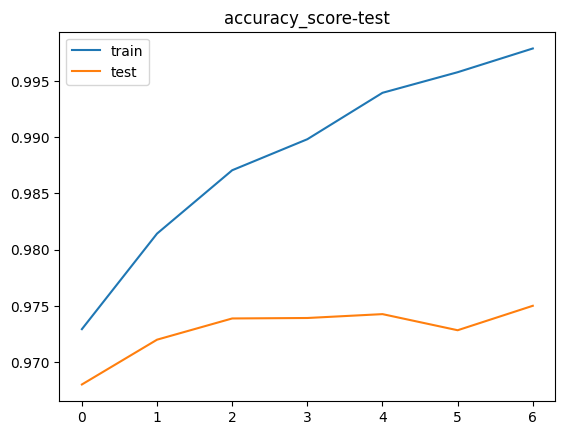

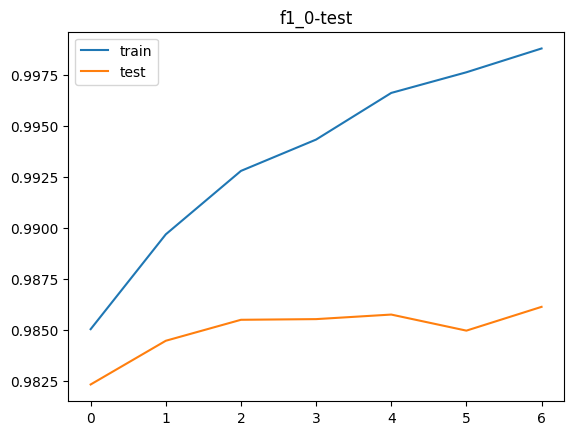

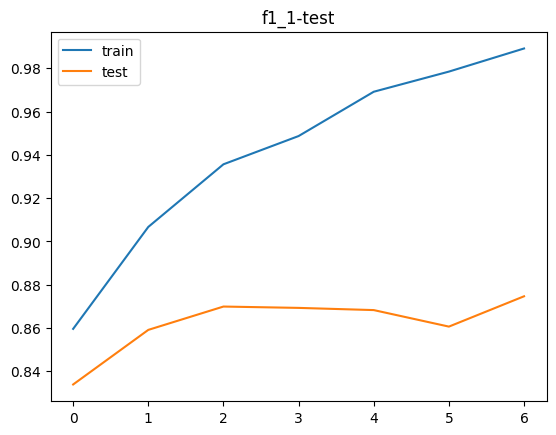

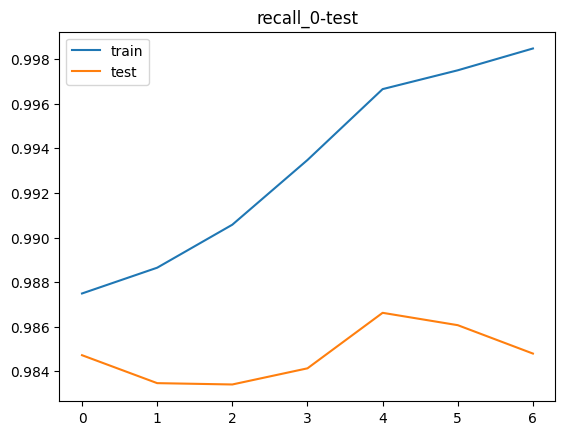

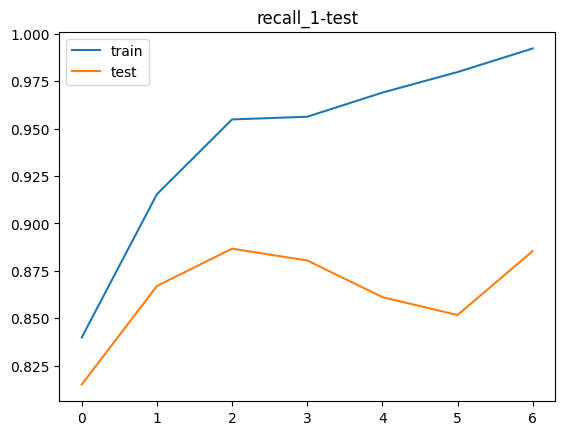

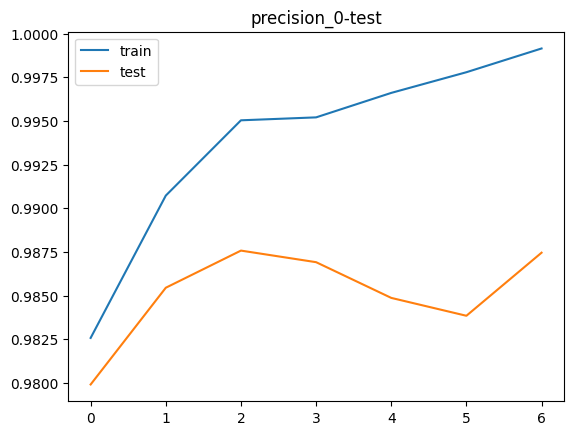

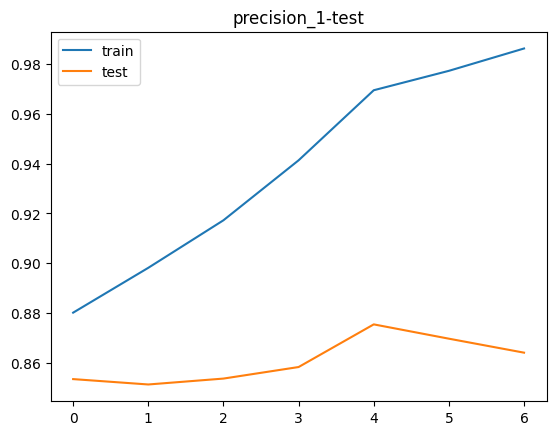

In [10]:
# TODO: number of labels should be from parameters
# final_df = pd.DataFrame([dir_names,final_results,eval_results]).T
final_df = pd.DataFrame([dir_names,eval_results]).T
# final_df.columns = ['name', 'res', 'score']
final_df.columns = ['name', 'score']
final_df["accuracy_score"] = final_df["score"].apply(lambda x:x["accuracy"]["eval_accuracy"])
final_df["f1_0"] = final_df["score"].apply(lambda x:x["f1"]["eval_f1"][0])
final_df["f1_1"] = final_df["score"].apply(lambda x:x["f1"]["eval_f1"][1])
# final_df["f1_2"] = final_df["score"].apply(lambda x:x["f1"]["eval_f1"][2])
final_df["recall_0"] = final_df["score"].apply(lambda x:x["recall"]["eval_recall"][0])
final_df["recall_1"] = final_df["score"].apply(lambda x:x["recall"]["eval_recall"][1])
# final_df["recall_2"] = final_df["score"].apply(lambda x:x["recall"]["eval_recall"][2])
final_df["precision_0"] = final_df["score"].apply(lambda x:x["precision"]["eval_precision"][0])
final_df["precision_1"] = final_df["score"].apply(lambda x:x["precision"]["eval_precision"][1])
# final_df["precision_2"] = final_df["score"].apply(lambda x:x["precision"]["eval_precision"][2])
skip = False
for score in final_df.columns[2:]:
    make_plot(score,"train")
    make_plot(score,"test")
    plt.legend(["train","test"])
    # plt.savefig(f"{score}.png")
    plt.savefig(os.path.join(SAVE_PATH,score) + "_score")
    plt.show()


In [ ]:
final_df